In [1]:
%matplotlib inline
morange = u'#ff7f0e'
mblue = u'#1f77b4'
mgreen = u'#2ca02c'
mred = u'#d62728'
mpurple = u'#9467bd'
import h5py

from cosmodc2.sdss_colors import load_umachine_processed_sdss_catalog
sdss = load_umachine_processed_sdss_catalog()
print(sdss.keys())
sdss = sdss[sdss['z'] < 0.07]

/Users/aphearin/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


['ra', 'dec', 'z', 'sm', 'ssfr', 'nd', 'restframe_extincted_sdss_abs_magr', 'restframe_extincted_sdss_gr', 'restframe_extincted_sdss_ri', 'size_kpc', 'dr7_PhotoObj_Table_ID', 'sfr_percentile_fixed_sm', 'gr_percentile_fixed_magr']


In [27]:
import os
from astropy.table import Table

dirname = "/Users/aphearin/Dropbox/protoDC2/protoDC2_v4p8"
basepat = "logsm_gt_sm9p0_recolored_umachine_color_mock_v4.8_m000-{0}.hdf5"

snapnum = 499
mock = Table.read(os.path.join(dirname, basepat.format(snapnum)), path='data')
print(mock.keys())

Lbox = 256.
Vbox = Lbox**3.
if snapnum == 392:
    snapshot_redshift = 0.2705
elif snapnum == 331:
    snapshot_redshift = 0.5
elif snapnum == 499:
    snapshot_redshift = 0.05
elif snapnum == 272:
    snapshot_redshift = 0.8
elif snapnum == 247:
    snapshot_redshift = 1.01
else:
    raise ValueError()

['source_halo_id', 'target_halo_id', 'host_halo_mvir', 'upid', 'mpeak', 'obs_sm', 'obs_sfr', 'sfr_percentile', 'restframe_extincted_sdss_abs_magr', 'restframe_extincted_sdss_gr', 'restframe_extincted_sdss_ri', 'is_on_red_sequence_gr', 'is_on_red_sequence_ri', '_obs_sm_orig_um_snap', 'x', 'y', 'z']


In [28]:
ls /Users/aphearin/Dropbox/protoDC2/protoDC2_v4p8

README.txt
logsm_gt_sm9p0_recolored_umachine_color_mock_v4.8_m000-247.hdf5
logsm_gt_sm9p0_recolored_umachine_color_mock_v4.8_m000-272.hdf5
logsm_gt_sm9p0_recolored_umachine_color_mock_v4.8_m000-331.hdf5
logsm_gt_sm9p0_recolored_umachine_color_mock_v4.8_m000-392.hdf5
logsm_gt_sm9p0_recolored_umachine_color_mock_v4.8_m000-499.hdf5
v4.8.all.aph_reduced.hdf5


## Remap $M_{\star}$

In [29]:
from cosmodc2.stellar_mass_remapping import remap_stellar_mass_in_snapshot

v4p8_default_z_table = [0.25, 0.5, 0.75, 1]
v4p8_default_slope_table = [0.45, 0.5, 0.65, 0.7]
v4p8_default_pivot_table = [13.5, 13.25, 13, 12.75]

new_z_table = [0.1, 0.2, 0.5, 0.65, 1]
new_slope_table = [0.5, 0.7, 0.7, 0.75, 0.75]
new_pivot_table = [13., 13., 13., 12.75, 12.75]

new_mstar = remap_stellar_mass_in_snapshot(
        snapshot_redshift, mock['mpeak'], mock['obs_sm'],
        z_table=new_z_table, slope_table=new_slope_table, 
        pivot_table=new_pivot_table)


## Inspect $\phi(M_\star)$ and $\langle M_\star\vert M_{\rm peak}\rangle$

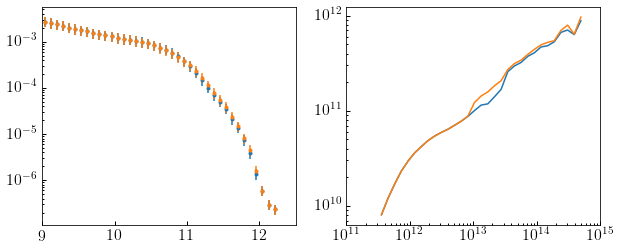

In [30]:
logsm_bins = np.linspace(9, 12.25, 40)
logsm_mids = 0.5*(logsm_bins[:-1] + logsm_bins[1:])

counts_v4p8, __ = np.histogram(np.log10(mock['obs_sm']), bins=logsm_bins)
counts_v4p11, __ = np.histogram(np.log10(new_mstar), bins=logsm_bins)

from scipy.stats import binned_statistic
logmpeak_bins = np.linspace(11.5, 14.75, 32)
logmpeak_mids = 0.5*(logmpeak_bins[:-1] + logmpeak_bins[1:])

median_logmstar_v4p8, __, __ = binned_statistic(
    np.log10(mock['mpeak']), np.log10(mock['obs_sm']), 
    bins=logmpeak_bins, statistic='median')
median_logmstar_v4p11, __, __ = binned_statistic(
    np.log10(mock['mpeak']), np.log10(new_mstar), 
    bins=logmpeak_bins, statistic='median')



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
yscale1 = ax1.set_yscale('log')
__=ax2.loglog()
xlim1 = ax1.set_xlim(9, 12.5)
xlim2 = ax2.set_xlim(1e11, 1e15)


__=ax1.errorbar(logsm_mids, counts_v4p8/Vbox, 0.25*counts_v4p8/Vbox, fmt='.')
__=ax1.errorbar(logsm_mids, counts_v4p11/Vbox, 0.25*counts_v4p11/Vbox, fmt='.')

__=ax2.plot(10**logmpeak_mids, 10**median_logmstar_v4p8)
__=ax2.plot(10**logmpeak_mids, 10**median_logmstar_v4p11)




(0.11064129668780831, 0.1226215644820296)


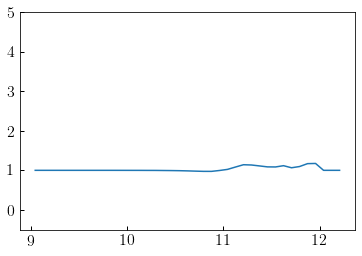

In [31]:
fig, ax = plt.subplots(1, 1)

__=ax.plot(logsm_mids, counts_v4p11/counts_v4p8.astype('f4'))
ylim = ax.set_ylim(-0.5, 5)

cenmask = mock['upid'] == -1
mstar_mask1 = mock['obs_sm'] > 10**11.5
mstar_mask2 = new_mstar > 10**11.5
fsat1 = np.count_nonzero(~cenmask  & mstar_mask1)/float(np.count_nonzero(mstar_mask1))
fsat2 = np.count_nonzero(~cenmask & mstar_mask2)/float(np.count_nonzero(mstar_mask1))
print(fsat1, fsat2)


## Remap $M_{\rm r}$

In [32]:
from cosmodc2.sdss_colors.sigmoid_magr_model import (
    magr_monte_carlo, median_magr_from_mstar)

kwargs = dict(high_mass_slope=1.8, magr_at_m0=-20.1)
new_magr = magr_monte_carlo(
    new_mstar, mock['upid'], np.zeros(len(mock)) + snapshot_redshift, **kwargs)

In [33]:
print(mock.keys())

['source_halo_id', 'target_halo_id', 'host_halo_mvir', 'upid', 'mpeak', 'obs_sm', 'obs_sfr', 'sfr_percentile', 'restframe_extincted_sdss_abs_magr', 'restframe_extincted_sdss_gr', 'restframe_extincted_sdss_ri', 'is_on_red_sequence_gr', 'is_on_red_sequence_ri', '_obs_sm_orig_um_snap', 'x', 'y', 'z']


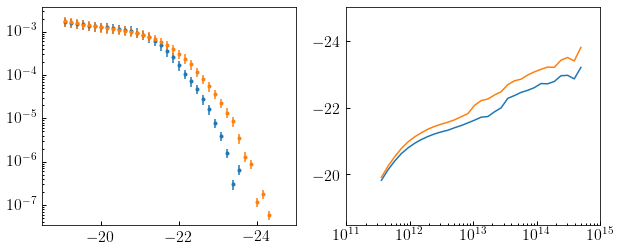

In [34]:
from scipy.stats import binned_statistic
logmpeak_bins = np.linspace(11.5, 14.75, 32)
logmpeak_mids = 0.5*(logmpeak_bins[:-1] + logmpeak_bins[1:])

median_magr_v4p8, __, __ = binned_statistic(
    np.log10(mock['mpeak']), mock['restframe_extincted_sdss_abs_magr'], 
    bins=logmpeak_bins, statistic='median')
median_magr_v4p11, __, __ = binned_statistic(
    np.log10(mock['mpeak']), new_magr, 
    bins=logmpeak_bins, statistic='median')

magr_bins = np.linspace(-25, -19, 40)
magr_mids = 0.5*(magr_bins[:-1] + magr_bins[1:])
counts_v4p8, __ = np.histogram(mock['restframe_extincted_sdss_abs_magr'], bins=magr_bins)
counts_v4p11, __ = np.histogram(new_magr, bins=magr_bins)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
xscale2 = ax2.set_xscale('log')
yscale1 = ax1.set_yscale('log')
xlim1 = ax1.set_xlim(-18.5, -25)
xlim2 = ax2.set_xlim(1e11, 1e15)
ylim2 = ax2.set_ylim(-18.5, -25)


__=ax1.errorbar(magr_mids, counts_v4p8/Vbox, 0.25*counts_v4p8/Vbox, fmt='.')
__=ax1.errorbar(magr_mids, counts_v4p11/Vbox, 0.25*counts_v4p11/Vbox, fmt='.')

__=ax2.plot(10**logmpeak_mids, median_magr_v4p8)
__=ax2.plot(10**logmpeak_mids, median_magr_v4p11)


In [35]:
bright_counts1 = np.count_nonzero(mock['restframe_extincted_sdss_abs_magr'] < -22)
bright_counts2 = np.count_nonzero(new_magr < -22)
fracdiff_bright_counts = bright_counts2/float(bright_counts1)
print("Fractional increase to bright galaxy counts = {0}".format(fracdiff_bright_counts))

Fractional increase to bright galaxy counts = 2.50684253916


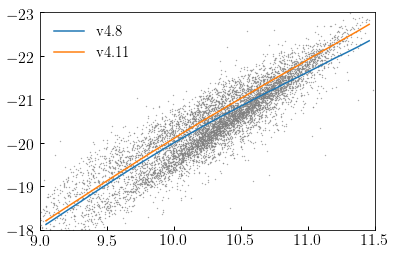

In [36]:

fig, ax = plt.subplots(1, 1)

nskip = 10
__=ax.scatter(sdss['sm'][::nskip], 
              sdss['restframe_extincted_sdss_abs_magr'][::nskip], 
              s=0.1, color='gray', label='')

from scipy.stats import binned_statistic
logsm_bins = np.linspace(9, 11.5, 30)
logsm_mids = 0.5*(logsm_bins[:-1] + logsm_bins[1:])
v4p8_median_magr, __, __ = binned_statistic(
    np.log10(mock['obs_sm']), mock['restframe_extincted_sdss_abs_magr'], 
    bins=logsm_bins, statistic='median')
v4p11_median_magr, __, __ = binned_statistic(
    np.log10(new_mstar), new_magr, 
    bins=logsm_bins, statistic='median')


__=ax.plot(logsm_mids, v4p8_median_magr, color=mblue, label=r'${\rm v4.8}$')
__=ax.plot(logsm_mids, v4p11_median_magr, color=morange, label=r'${\rm v4.11}$')
leg = ax.legend()
xlim = ax.set_xlim(9, 11.5)
ylim = ax.set_ylim(-18, -23)



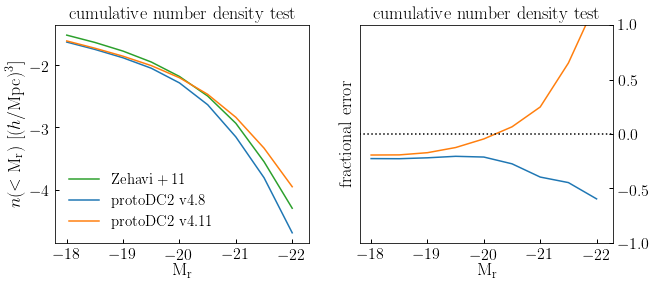

In [37]:
from cosmodc2.sdss_colors import zehavi11_cumulative_nd
lumthresh_h1p0, cumnd_sdss = zehavi11_cumulative_nd()

from cosmodc2.mock_diagnostics import cumulative_nd

volume_v4 = Lbox**3.
protoDC2_littleh = 0.7
cumnd_pdc2_v4p8 = cumulative_nd(mock['restframe_extincted_sdss_abs_magr'], 
                           volume_v4, protoDC2_littleh, lumthresh_h1p0)
cumnd_pdc2_v4p11 = cumulative_nd(new_magr, 
                           volume_v4, protoDC2_littleh, lumthresh_h1p0)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

__=ax1.plot(lumthresh_h1p0, np.log10(cumnd_sdss), label=r'${\rm Zehavi+11}$', color=mgreen)
__=ax1.plot(lumthresh_h1p0, np.log10(cumnd_pdc2_v4p8), 
            label=r'${\rm protoDC2\ v4.8}$', color=mblue)
__=ax1.plot(lumthresh_h1p0, np.log10(cumnd_pdc2_v4p11), 
            label=r'${\rm protoDC2\ v4.11}$', color=morange)

fracdiff_pdc2_v4p8 = (cumnd_pdc2_v4p8 - cumnd_sdss)/cumnd_sdss
fracdiff_pdc2_v4p11 = (cumnd_pdc2_v4p11 - cumnd_sdss)/cumnd_sdss

__=ax2.plot(lumthresh_h1p0, fracdiff_pdc2_v4p8, 
            label=r'${\rm protoDC2\ v4.8}$', color=mblue)
__=ax2.plot(lumthresh_h1p0, fracdiff_pdc2_v4p11, 
            label=r'${\rm protoDC2\ v4.11}$', color=morange)

__=ax2.plot(np.linspace(-100, 100, 100), np.zeros(100), ':', color='k')

legend = ax1.legend()
xlabel = ax1.set_xlabel(r'${\rm M_{r}}$')
xlabel2 = ax2.set_xlabel(r'${\rm M_{r}}$')
ylabel2 = ax2.set_ylabel(r'${\rm fractional\ error}$')
ylabel = ax1.set_ylabel(r'$n(<{\rm M_r})\ [(h/{\rm Mpc})^3]$')
title1 = ax1.set_title(r'${\rm cumulative\ number\ density\ test}$')
title2 = ax2.set_title(r'${\rm cumulative\ number\ density\ test}$')
ax2.yaxis.tick_right()  
xlim1 = ax1.set_xlim(-17.8, -22.3)
ylim2 = ax2.set_ylim(-1, 1)


In [38]:
from cosmodc2.mock_diagnostics import zehavi_wp

period = Lbox
x, y, z, vz = mock['x'], mock['y'], mock['z'], np.zeros(len(mock))
rp_mids, wp_v4p8_19p0 = zehavi_wp(x, y, z, vz, 
            period, mock['restframe_extincted_sdss_abs_magr'], -19.0, protoDC2_littleh)
rp_mids, wp_v4p8_19p5 = zehavi_wp(x, y, z, vz, 
            period, mock['restframe_extincted_sdss_abs_magr'], -19.5, protoDC2_littleh)
rp_mids, wp_v4p8_20p5 = zehavi_wp(x, y, z, vz, 
            period, mock['restframe_extincted_sdss_abs_magr'], -20.5, protoDC2_littleh)
rp_mids, wp_v4p8_21p5 = zehavi_wp(x, y, z, vz, 
            period, mock['restframe_extincted_sdss_abs_magr'], -21.5, protoDC2_littleh)

rp_mids, wp_v4p11_19p0 = zehavi_wp(x, y, z, vz, 
            period, new_magr, -19.0, protoDC2_littleh)
rp_mids, wp_v4p11_19p5 = zehavi_wp(x, y, z, vz, 
            period, new_magr, -19.5, protoDC2_littleh)
rp_mids, wp_v4p11_20p5 = zehavi_wp(x, y, z, vz, 
            period, new_magr, -20.5, protoDC2_littleh)
rp_mids, wp_v4p11_21p5 = zehavi_wp(x, y, z, vz, 
            period, new_magr, -21.5, protoDC2_littleh)


...calculating wp for 1.00e+05 galaxies and Mr < -19.0
...calculating wp for 1.00e+05 galaxies and Mr < -19.5
...calculating wp for 3.87e+04 galaxies and Mr < -20.5
...calculating wp for 2.60e+03 galaxies and Mr < -21.5
...calculating wp for 1.00e+05 galaxies and Mr < -19.0
...calculating wp for 9.99e+04 galaxies and Mr < -19.5
...calculating wp for 5.69e+04 galaxies and Mr < -20.5
...calculating wp for 7.76e+03 galaxies and Mr < -21.5


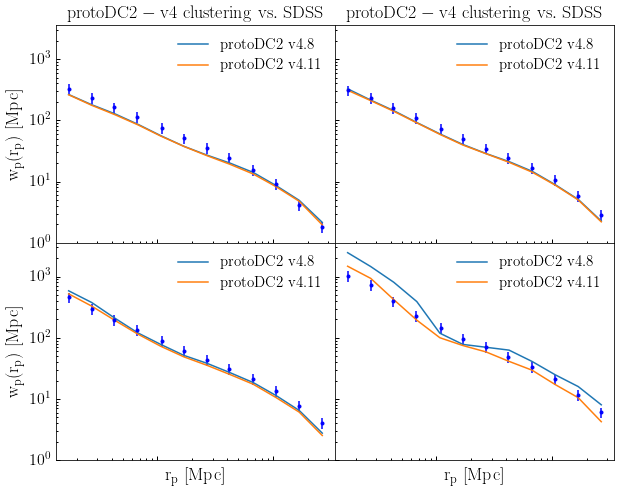

In [39]:
from cosmodc2.sdss_colors.sdss_measurements import rp as rp_zehavi
from cosmodc2.sdss_colors import zehavi11_clustering

wp_zehavi_18p5 = zehavi11_clustering(-18.5)
wp_zehavi_19p0 = zehavi11_clustering(-19.0)
wp_zehavi_19p5 = zehavi11_clustering(-19.5)
wp_zehavi_20p0 = zehavi11_clustering(-20.0)
wp_zehavi_20p5 = zehavi11_clustering(-20.5)
wp_zehavi_21p0 = zehavi11_clustering(-21.0)
wp_zehavi_21p5 = zehavi11_clustering(-21.5)

fig, _axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

((ax1, ax2), (ax3, ax4)) = _axes
axes = ax1, ax2, ax3, ax4
for ax in axes:
    __=ax.loglog()


__=ax1.plot(rp_mids, wp_v4p8_19p0,  color=mblue, label=r'${\rm protoDC2\ v4.8}$')
__=ax1.plot(rp_mids, wp_v4p11_19p0,  color=morange, label=r'${\rm protoDC2\ v4.11}$')
__=ax1.errorbar(rp_zehavi, wp_zehavi_19p0, 0.2*wp_zehavi_19p0, 
               fmt='.', color='blue')
np.save('wp_v4p11_19p0_{0}'.format(snapnum), wp_v4p11_19p0)
np.save('rp_mids', rp_mids)

__=ax2.plot(rp_mids, wp_v4p8_19p5,  color=mblue, label=r'${\rm protoDC2\ v4.8}$')
__=ax2.plot(rp_mids, wp_v4p11_19p5,  color=morange, label=r'${\rm protoDC2\ v4.11}$')
__=ax2.errorbar(rp_zehavi, wp_zehavi_19p5, 0.2*wp_zehavi_19p5, 
               fmt='.', color='blue')
np.save('wp_v4p11_19p5_{0}'.format(snapnum), wp_v4p11_19p5)

__=ax3.plot(rp_mids, wp_v4p8_20p5,  color=mblue, label=r'${\rm protoDC2\ v4.8}$')
__=ax3.plot(rp_mids, wp_v4p11_20p5,  color=morange, label=r'${\rm protoDC2\ v4.11}$')
__=ax3.errorbar(rp_zehavi, wp_zehavi_20p5, 0.2*wp_zehavi_20p5, 
               fmt='.', color='blue')
np.save('wp_v4p11_20p5_{0}'.format(snapnum), wp_v4p11_20p5)

__=ax4.plot(rp_mids, wp_v4p8_21p5,  color=mblue, label=r'${\rm protoDC2\ v4.8}$')
__=ax4.plot(rp_mids, wp_v4p11_21p5,  color=morange, label=r'${\rm protoDC2\ v4.11}$')
__=ax4.errorbar(rp_zehavi, wp_zehavi_21p5, 0.2*wp_zehavi_21p5, 
               fmt='.', color='blue')
np.save('wp_v4p11_21p5_{0}'.format(snapnum), wp_v4p11_21p5)

for ax in axes:
    leg = ax.legend()

title1 = ax1.set_title(r'${\rm protoDC2-v4\ clustering\ vs.\ SDSS}$')
title2 = ax2.set_title(r'${\rm protoDC2-v4\ clustering\ vs.\ SDSS}$')

xlabel3 = ax3.set_xlabel(r'${\rm r_p\ [Mpc]}$')
xlabel4 = ax4.set_xlabel(r'${\rm r_p\ [Mpc]}$')
ylabel1 = ax1.set_ylabel(r'${\rm w_p(r_p)\ [Mpc]}$')
ylabel3 = ax3.set_ylabel(r'${\rm w_p(r_p)\ [Mpc]}$')

__=ax1.set_xticklabels([''])
__=ax2.set_xticklabels([''])

# figname = 'luminosity_dependent_clustering_pdc2_v4_vs_zehavi11.pdf'
# fig.savefig(figname, bbox_extra_artists=[xlabel], bbox_inches='tight')

In [40]:
ls *.npy

rp_mids.npy            wp_v4p11_19p5_272.npy  wp_v4p11_20p5_392.npy
wp_v4p11_19p0_247.npy  wp_v4p11_19p5_331.npy  wp_v4p11_20p5_499.npy
wp_v4p11_19p0_272.npy  wp_v4p11_19p5_392.npy  wp_v4p11_21p5_247.npy
wp_v4p11_19p0_331.npy  wp_v4p11_19p5_499.npy  wp_v4p11_21p5_272.npy
wp_v4p11_19p0_392.npy  wp_v4p11_20p5_247.npy  wp_v4p11_21p5_331.npy
wp_v4p11_19p0_499.npy  wp_v4p11_20p5_272.npy  wp_v4p11_21p5_392.npy
wp_v4p11_19p5_247.npy  wp_v4p11_20p5_331.npy  wp_v4p11_21p5_499.npy


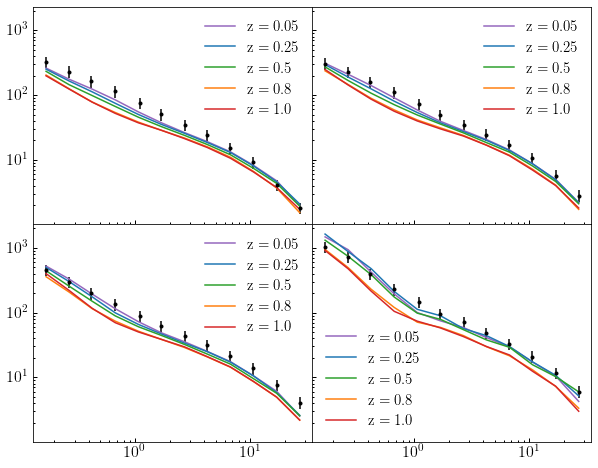

In [41]:
wp_v4p11_19p0_247 = np.load('wp_v4p11_19p0_247.npy')
wp_v4p11_19p5_247 = np.load('wp_v4p11_19p5_247.npy')
wp_v4p11_20p5_247 = np.load('wp_v4p11_20p5_247.npy')
wp_v4p11_21p5_247 = np.load('wp_v4p11_21p5_247.npy')

wp_v4p11_19p0_272 = np.load('wp_v4p11_19p0_272.npy')
wp_v4p11_19p5_272 = np.load('wp_v4p11_19p5_272.npy')
wp_v4p11_20p5_272 = np.load('wp_v4p11_20p5_272.npy')
wp_v4p11_21p5_272 = np.load('wp_v4p11_21p5_272.npy')

wp_v4p11_19p0_331 = np.load('wp_v4p11_19p0_331.npy')
wp_v4p11_19p5_331 = np.load('wp_v4p11_19p5_331.npy')
wp_v4p11_20p5_331 = np.load('wp_v4p11_20p5_331.npy')
wp_v4p11_21p5_331 = np.load('wp_v4p11_21p5_331.npy')

wp_v4p11_19p0_392 = np.load('wp_v4p11_19p0_392.npy')
wp_v4p11_19p5_392 = np.load('wp_v4p11_19p5_392.npy')
wp_v4p11_20p5_392 = np.load('wp_v4p11_20p5_392.npy')
wp_v4p11_21p5_392 = np.load('wp_v4p11_21p5_392.npy')

wp_v4p11_19p0_499 = np.load('wp_v4p11_19p0_499.npy')
wp_v4p11_19p5_499 = np.load('wp_v4p11_19p5_499.npy')
wp_v4p11_20p5_499 = np.load('wp_v4p11_20p5_499.npy')
wp_v4p11_21p5_499 = np.load('wp_v4p11_21p5_499.npy')

rp_mids = np.load('rp_mids.npy')

fig, _axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

((ax1, ax2), (ax3, ax4)) = _axes
axes = ax1, ax2, ax3, ax4
for ax in axes:
    __=ax.loglog()


__=ax1.plot(rp_mids, wp_v4p11_19p0_499,  color=mpurple, label=r'${\rm z=0.05}$')
__=ax1.plot(rp_mids, wp_v4p11_19p0_392,  color=mblue, label=r'${\rm z=0.25}$')
__=ax1.plot(rp_mids, wp_v4p11_19p0_331,  color=mgreen, label=r'${\rm z=0.5}$')
__=ax1.plot(rp_mids, wp_v4p11_19p0_272,  color=morange, label=r'${\rm z=0.8}$')
__=ax1.plot(rp_mids, wp_v4p11_19p0_247,  color=mred, label=r'${\rm z=1.0}$')

__=ax2.plot(rp_mids, wp_v4p11_19p5_499,  color=mpurple, label=r'${\rm z=0.05}$')
__=ax2.plot(rp_mids, wp_v4p11_19p5_392,  color=mblue, label=r'${\rm z=0.25}$')
__=ax2.plot(rp_mids, wp_v4p11_19p5_331,  color=mgreen, label=r'${\rm z=0.5}$')
__=ax2.plot(rp_mids, wp_v4p11_19p5_272,  color=morange, label=r'${\rm z=0.8}$')
__=ax2.plot(rp_mids, wp_v4p11_19p5_247,  color=mred, label=r'${\rm z=1.0}$')

__=ax3.plot(rp_mids, wp_v4p11_20p5_499,  color=mpurple, label=r'${\rm z=0.05}$')
__=ax3.plot(rp_mids, wp_v4p11_20p5_392,  color=mblue, label=r'${\rm z=0.25}$')
__=ax3.plot(rp_mids, wp_v4p11_20p5_331,  color=mgreen, label=r'${\rm z=0.5}$')
__=ax3.plot(rp_mids, wp_v4p11_20p5_272,  color=morange, label=r'${\rm z=0.8}$')
__=ax3.plot(rp_mids, wp_v4p11_20p5_247,  color=mred, label=r'${\rm z=1.0}$')

__=ax4.plot(rp_mids, wp_v4p11_21p5_499,  color=mpurple, label=r'${\rm z=0.05}$')
__=ax4.plot(rp_mids, wp_v4p11_21p5_392,  color=mblue, label=r'${\rm z=0.25}$')
__=ax4.plot(rp_mids, wp_v4p11_21p5_331,  color=mgreen, label=r'${\rm z=0.5}$')
__=ax4.plot(rp_mids, wp_v4p11_21p5_272,  color=morange, label=r'${\rm z=0.8}$')
__=ax4.plot(rp_mids, wp_v4p11_21p5_247,  color=mred, label=r'${\rm z=1.0}$')



__=ax1.errorbar(rp_zehavi, wp_zehavi_19p0, 0.2*wp_zehavi_19p0, 
               fmt='.', color='k')
__=ax2.errorbar(rp_zehavi, wp_zehavi_19p5, 0.2*wp_zehavi_19p5, 
               fmt='.', color='k')
__=ax3.errorbar(rp_zehavi, wp_zehavi_20p5, 0.2*wp_zehavi_20p5, 
               fmt='.', color='k')
__=ax4.errorbar(rp_zehavi, wp_zehavi_21p5, 0.2*wp_zehavi_21p5, 
               fmt='.', color='k')

for ax in axes:
    __=ax.legend()

In [42]:
wp_v4p11_21p5_247/wp_v4p11_21p5_499

array([0.61614816, 0.50813063, 0.50958937, 0.53892858, 0.73625198,
       0.77714459, 0.72524562, 0.72770539, 0.75037326, 0.72084923,
       0.69593211, 0.70543149])

['source_halo_id', 'target_halo_id', 'host_halo_mvir', 'upid', 'mpeak', 'obs_sm', 'obs_sfr', 'sfr_percentile', 'restframe_extincted_sdss_abs_magr', 'restframe_extincted_sdss_gr', 'restframe_extincted_sdss_ri', 'is_on_red_sequence_gr', 'is_on_red_sequence_ri', '_obs_sm_orig_um_snap', 'x', 'y', 'z']


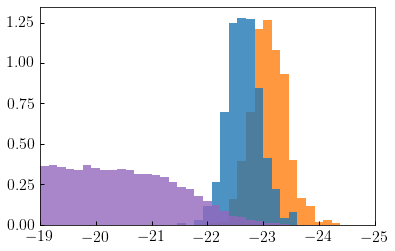

In [43]:
print(mock.keys())


cluster_halo_mask = mock['host_halo_mvir'] > 10**13.75
cenmask = mock['upid'] == -1

fig, ax = plt.subplots(1, 1)

magr_bins = np.linspace(-25, -19, 40)
magr_mids = 0.5*(magr_bins[:-1] + magr_bins[1:])

__=ax.hist(new_magr[cenmask & cluster_halo_mask], bins=magr_bins, normed=True, 
               alpha=0.8,color=morange)
__=ax.hist(mock['restframe_extincted_sdss_abs_magr'][cenmask & cluster_halo_mask], 
               bins=magr_bins, normed=True, alpha=0.8,color=mblue)
__=ax.hist(new_magr[~cenmask & cluster_halo_mask], bins=magr_bins, normed=True, 
               alpha=0.8,color=mpurple)

xlim = ax.set_xlim(-19, -25)